# Midterm Project

> Develop classification models to predict a target variable.
> Evaluate the classification models based on the different performance metrics.

[Link to Dataset](https://www.kaggle.com/datasets/adeniranstephen/obesity-prediction-dataset)

In [511]:
# Import dataset
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline

raw = pd.read_csv('data/obesity_dataset.csv')

raw = raw.sample(frac=1).reset_index(drop=True)

raw

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,40,1.57,80.09,yes,yes,2.07,2.98,Sometimes,no,1.47,no,0.00,0.000,no,Automobile,Obesity_Type_I
1,Male,18,1.74,64.00,no,no,3.00,3.00,Sometimes,no,2.00,yes,0.00,1.000,no,Public_Transportation,Normal_Weight
2,Male,18,1.72,52.06,yes,yes,1.95,3.00,Sometimes,no,1.75,no,0.20,1.743,Sometimes,Public_Transportation,Insufficient_Weight
3,Male,23,1.76,119.19,yes,yes,2.01,2.95,Sometimes,no,1.97,no,1.59,0.839,Sometimes,Public_Transportation,Obesity_Type_II
4,Male,25,1.77,114.16,yes,yes,2.16,3.00,Sometimes,no,2.12,no,1.33,0.053,Sometimes,Public_Transportation,Obesity_Type_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,17,1.58,50.00,no,yes,1.00,4.00,Frequently,no,2.00,no,1.00,2.000,Sometimes,Public_Transportation,Normal_Weight
2107,Male,24,1.77,119.08,yes,yes,2.43,3.00,Sometimes,no,2.02,no,1.58,0.532,Sometimes,Public_Transportation,Obesity_Type_II
2108,Female,24,1.70,81.11,yes,yes,2.04,2.98,Sometimes,no,1.52,no,0.50,1.029,Sometimes,Public_Transportation,Overweight_Level_II
2109,Male,23,1.80,89.87,yes,yes,1.57,1.89,Sometimes,no,2.00,no,0.00,0.552,Sometimes,Public_Transportation,Overweight_Level_II


### Data Cleaning

1. CALC, CAEC Column must only have the values [Never, Sometimes, Frequently, Always]
2. Change underscores to whitespace
3. Apply One Hot Encoding for Categorical Values
4. Apply Standard Scaler for Numeric Values
5. Apply K-Bins Discretizer for Numeric Values (Categorical Naive Bayes)

In [512]:
# Cleanup CALC and CAEC [Transform no to Never]
raw['CALC'] = raw['CALC'].replace("no", "Never")
raw['CAEC'] = raw['CAEC'].replace("no", "Never")

# Change underscore values to whitespace and standardized
# Replace underscores in COLUMN NAMES (if they exist)
raw.columns = raw.columns.str.replace('_', ' ')

# Apply title case ONLY to column names containing spaces (multi-word columns)
raw.columns = [
    col.title() if ' ' in col else col  # Title case only if space exists
    for col in raw.columns
]

# Replace underscores in DATA ROWS for specific columns
for col in ['MTRANS', 'NObeyesdad']:
    raw[col] = raw[col].astype(str).str.replace('_', ' ', regex=True)

# Columns to standardize to title case
title_case_columns = [
    'Family History With Overweight',  # After underscore replacement
    'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC'
]

# Convert values in these columns to title case
raw[title_case_columns] = raw[title_case_columns].apply(lambda x: x.astype(str).str.title())
# Split data into categorical and numeric
categorical_cols = [
    'Gender', 'Family History With Overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'
]
numerical_cols = [
    'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'
]

# Create Preprocessor
cnb_preprocessor = ColumnTransformer(
    transformers=[
        ('num', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), numerical_cols),
        # Discretize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categoricals
    ]
)
svm_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Encode categoricals
    ]
)

### Prepare Data

1. Split features and target column
2. Prepare training and testing data.

In [513]:
# Split the dataset (unseen = 90% of dataset), (data = 10% of dataset)
unseen = raw.iloc[1900:2110].reset_index(drop=True)  # Get unseen sample
data = raw.iloc[0:1899].reset_index(drop=True)  # Cut original dataset

# Split Features and Target Column
features = data.drop('NObeyesdad', axis=1).copy()
target_col = data['NObeyesdad'].copy()

features_train, features_test, target_train, target_test = train_test_split(
    features, target_col, test_size=0.2
)

### Train Categorical Naive Bayes Model

In [514]:
cnb_model = Pipeline([
    ('preprocessor', cnb_preprocessor),
    ('classifier', CategoricalNB())
])

cnb_model.fit(features_train, target_train)

cnb_pred_train = cnb_model.predict(features_train)
cnb_pred_test = cnb_model.predict(features_test)

### Train Support Vector Machine Model

In [515]:
svm_model = Pipeline([
    ('preprocessor', svm_preprocessor),
    ('classifier', SVC(
        C=1.0,
        gamma='scale',
        probability=True,
        class_weight='balanced'  # Handles class imbalance
    ))
])

svm_model.fit(features_train, target_train)

svm_pred_train = svm_model.predict(features_train)
svm_pred_test = svm_model.predict(features_test)

### Train Random Forest Classifier Model

In [516]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = Pipeline([
    ('preprocessor', svm_preprocessor),
    ('classifier', RandomForestClassifier(
        class_weight='balanced'  # Handle class imbalance
    ))
])

rfc_model.fit(features_train, target_train)

rfc_pred_train = rfc_model.predict(features_train)
rfc_pred_test = rfc_model.predict(features_test)

### Display Confusion Matrices for every model

In [529]:
import seaborn as sns

# Prepare Matrices
cnb_confmtrx = confusion_matrix(target_train, cnb_model.predict(features_train))
svm_confmtrx = confusion_matrix(target_train, svm_model.predict(features_train))
rfc_confmtrx = confusion_matrix(target_train, rfc_model.predict(features_train))
labels = ['Obesity Type I','Obesity Type III','Obesity Type II','Overweight Level II','Overweight Level I','Normal Weight','Insufficient Weight']

array([[160,  23,   0,   2,   0,  12,   3],
       [ 30, 139,   3,   0,   0,  13,  16],
       [  1,   4, 157,  55,   7,  12,  14],
       [  0,   1,  12, 202,   0,   1,   2],
       [  0,   0,   0,   0, 230,   0,   0],
       [ 12,  24,  37,   5,   0, 101,  35],
       [  3,  21,  46,  24,   1,  13,  98]])

<Axes: >

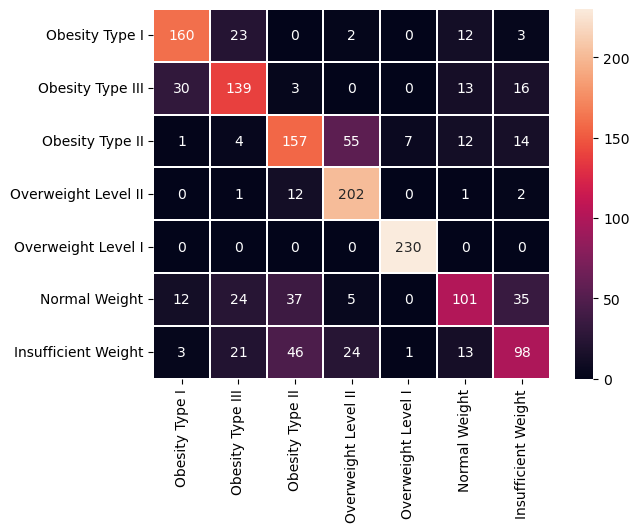

In [530]:
sns.heatmap(cnb_confmtrx, annot=True, linewidths = 0.01 ,xticklabels=labels, yticklabels=labels, fmt='d')

<Axes: >

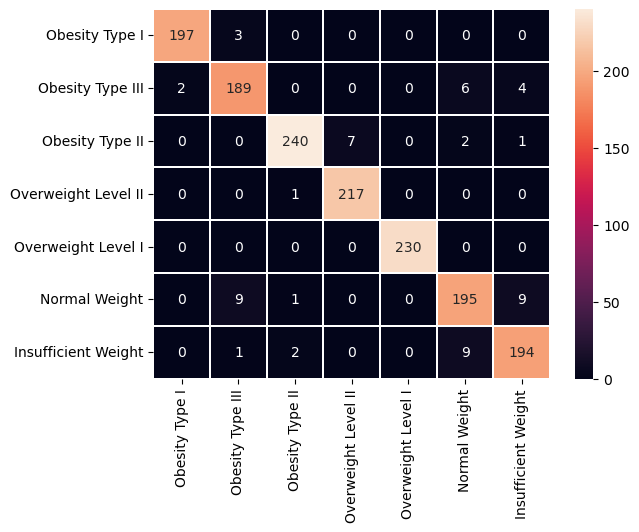

In [532]:
sns.heatmap(svm_confmtrx, annot=True, linewidths = 0.01 ,xticklabels=labels, yticklabels=labels, fmt='d')

<Axes: >

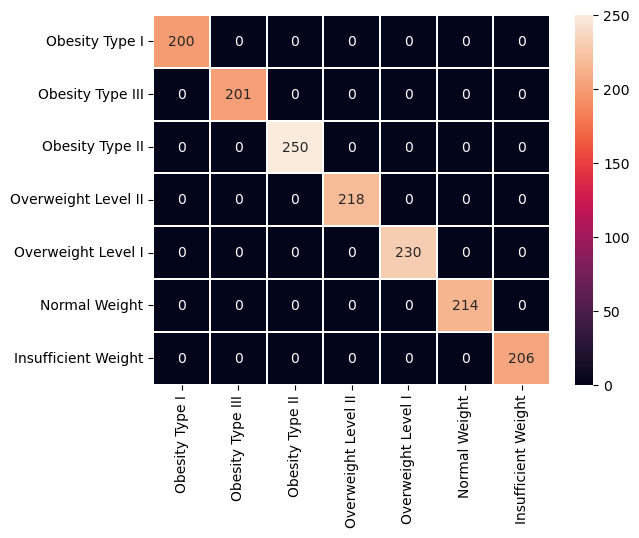

In [531]:
sns.heatmap(rfc_confmtrx, annot=True, linewidths = 0.01 ,xticklabels=labels, yticklabels=labels, fmt='d')

### Get Accuracy, Precision, Recall, and ROC-AUC Scores for all Models
The mean value of every result from the Ten-Fold Validation is displayed

In [521]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
apr_results = pd.DataFrame({
    'Results': ['Categorical Naive Bayes', 'Support Vector Machine', 'Random Forest Classifier'],
    'Testing Accuracy': [cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='accuracy').mean(),
                         cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='accuracy').mean(),
                         cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='accuracy').mean()],
    'Testing Precision': [
        cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='precision_weighted').mean()],
    'Testing Recall': [cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='recall_weighted').mean(),
                       cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='recall_weighted').mean(),
                       cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='recall_weighted').mean()],
    'Testing ROC-AUC': [cross_val_score(cnb_model, features_test, target_test, cv=cv, scoring='roc_auc_ovr').mean(),
                        cross_val_score(svm_model, features_test, target_test, cv=cv, scoring='roc_auc_ovr').mean(),
                        cross_val_score(rfc_model, features_test, target_test, cv=cv, scoring='roc_auc_ovr').mean()],
    'Training Accuracy': [cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='accuracy').mean(),
                          cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='accuracy').mean(),
                          cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='accuracy').mean()],
    'Training Precision': [
        cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='precision_weighted').mean(),
        cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='precision_weighted').mean()],
    'Training Recall': [
        cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='recall_weighted').mean(),
        cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='recall_weighted').mean(),
        cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='recall_weighted').mean()],
    'Training ROC-AUC': [cross_val_score(cnb_model, features_train, target_train, cv=cv, scoring='roc_auc_ovr').mean(),
                         cross_val_score(svm_model, features_train, target_train, cv=cv, scoring='roc_auc_ovr').mean(),
                         cross_val_score(rfc_model, features_train, target_train, cv=cv, scoring='roc_auc_ovr').mean()]
})

apr_results

,Results,Testing Accuracy,Testing Precision,Testing Recall,Testing ROC-AUC,Training Accuracy,Training Precision,Training Recall,Training ROC-AUC
0,Categorical Naive Bayes,0.686842,0.696907,0.686842,0.933526,0.695203,0.692366,0.695203,0.931821
1,Support Vector Machine,0.773684,0.812701,0.773684,0.968234,0.916434,0.920847,0.916434,0.993095
2,Random Forest Classifier,0.871053,0.888342,0.863158,0.982216,0.932847,0.938418,0.936794,0.993715


### Test models using the unseen dataset

In [522]:
expected = unseen['NObeyesdad'].copy()

# Categorical Naive Bayes
cnb_unseen = unseen.copy()
cnb_unseen.drop('NObeyesdad', axis=1, inplace=True)
cnb_unseen['Predictions'] = cnb_model.predict(cnb_unseen)
cnb_comparison = pd.DataFrame({
    'Expected': expected,
    'Actual': cnb_unseen['Predictions'],
})

# Support Vector Model
svm_unseen = unseen.copy()
svm_unseen.drop('NObeyesdad', axis=1, inplace=True)
svm_unseen['Predictions'] = svm_model.predict(svm_unseen)
svm_comparison = pd.DataFrame({
    'Expected': expected,
    'Actual': svm_unseen['Predictions'],
})

# Support Vector Model
rfc_unseen = unseen.copy()
rfc_unseen.drop('NObeyesdad', axis=1, inplace=True)
rfc_unseen['Predictions'] = rfc_model.predict(rfc_unseen)
rfc_comparison = pd.DataFrame({
    'Expected': expected,
    'Actual': rfc_unseen['Predictions'],
})

# Match Counter
def match_count(df):
    col1, col2 = df.columns
    matches = (df[col1] == df[col2]).sum()
    mismatches = len(df) - matches
    return [matches, mismatches]

In [523]:
matches = match_count(cnb_comparison)
print("Categorical Naive Bayes Test")
print('Matches: ', matches[0], ' | Mismatches: ', matches[1])
cnb_comparison

Categorical Naive Bayes Test
Matches:  146  | Mismatches:  64


,Expected,Actual
0,Obesity Type I,Obesity Type I
1,Insufficient Weight,Insufficient Weight
2,Overweight Level II,Overweight Level II
3,Normal Weight,Insufficient Weight
4,Insufficient Weight,Insufficient Weight
...,...,...
205,Insufficient Weight,Normal Weight
206,Normal Weight,Insufficient Weight
207,Obesity Type II,Obesity Type II
208,Overweight Level II,Overweight Level II


In [524]:
matches = match_count(svm_comparison)
print("Support Vector Machine Test")
print('Matches: ', matches[0], ' | Mismatches: ', matches[1])
svm_comparison

Support Vector Machine Test
Matches:  186  | Mismatches:  24


,Expected,Actual
0,Obesity Type I,Obesity Type I
1,Insufficient Weight,Insufficient Weight
2,Overweight Level II,Overweight Level II
3,Normal Weight,Insufficient Weight
4,Insufficient Weight,Insufficient Weight
...,...,...
205,Insufficient Weight,Insufficient Weight
206,Normal Weight,Insufficient Weight
207,Obesity Type II,Obesity Type II
208,Overweight Level II,Overweight Level I


In [525]:
matches = match_count(rfc_comparison)
print("Random Forest Classifier")
print('Matches: ', matches[0], ' | Mismatches: ', matches[1])
rfc_comparison

Random Forest Classifier
Matches:  199  | Mismatches:  11


,Expected,Actual
0,Obesity Type I,Obesity Type I
1,Insufficient Weight,Normal Weight
2,Overweight Level II,Overweight Level II
3,Normal Weight,Normal Weight
4,Insufficient Weight,Insufficient Weight
...,...,...
205,Insufficient Weight,Insufficient Weight
206,Normal Weight,Normal Weight
207,Obesity Type II,Obesity Type II
208,Overweight Level II,Overweight Level II
